# Transformer Analysis
 Using the TranformerLens and SAELens libraries we analyzed the behavior of LLaVA using a pre-trained SAE on Gemma-2B

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import contextlib
import requests
import torch
import transformer_lens
import transformers
from tempfile import TemporaryDirectory
from PIL import Image

es = contextlib.ExitStack()
es.enter_context(torch.inference_mode())

model_name = "Intel/llava-gemma-2b"
model = transformers.AutoModelForImageTextToText.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)
processor = transformers.AutoProcessor.from_pretrained(model_name)
processor.patch_size = model.config.vision_config.patch_size
processor.vision_feature_select_strategy = model.config.vision_feature_select_strategy

def get_hooked_model(model, tokenizer):
    with TemporaryDirectory() as model_name:
        model.config.save_pretrained(model_name)
        cfg = transformer_lens.loading.get_pretrained_model_config(
            model_name,
            device=model.device,
            dtype=model.dtype,
        )
        state_dict = transformer_lens.loading.get_pretrained_state_dict(
            model_name,
            cfg,
            model,
        )
        for k, v in state_dict.items():
            if v.device != model.device:
                state_dict[k] = v.to(model.device)
    hooked_model = transformer_lens.HookedTransformer(cfg, tokenizer)
    hooked_model.load_and_process_state_dict(
        state_dict,
        fold_ln=False,
        center_writing_weights=False,
        center_unembed=False,
        fold_value_biases=False,
    )
    return hooked_model

def get_input_embeds(input_ids, pixel_values):
    input_embeds = model.get_input_embeddings()(input_ids)
    image_features = model.get_image_features(
        pixel_values,
        model.config.vision_feature_layer,
        model.config.vision_feature_select_strategy,
    )
    input_embeds[input_ids == model.config.image_token_index] = image_features
    return input_embeds

def embed(prompt, image):
    inp = processor(image, prompt, return_tensors="pt").to(model.device)
    input_embeds = get_input_embeds(inp.input_ids, inp.pixel_values)
    input_embeds *= hooked_model.cfg.d_model ** 0.5
    return input_embeds


def run_model(prompt, image, **kwds):
    input_embeds = embed(prompt, image)
    return hooked_model.run_with_cache(input_embeds, start_at_layer=0, **kwds)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
hooked_model = get_hooked_model(model.language_model, processor.tokenizer)

In [6]:
conversation = [{"role": "user", "content": processor.image_token + "\ndescribe the image"}]
prompt = processor.tokenizer.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

image = requests.get("https://llava-vl.github.io/static/images/view.jpg", stream=True)
image = Image.open(image.raw)


In [7]:
# from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer
import transformer_lens.utils as utils

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-2b-res-jb",  # <- Release name
    sae_id="blocks.12.hook_resid_post",  # <- SAE id (not always a hook point!)
    device='cuda:0',
)

In [8]:
def make_hook(idx, amt):
    encoded = torch.zeros(sae.cfg.d_sae, device=model.device)
    bias = sae.decode(encoded)
    encoded[idx] = amt
    decoded = sae.decode(encoded) - bias
    def boost(value, hook):
        value += decoded
        return value
    return [(sae.cfg.hook_name, boost)]

def hooked_generate(prompt, image, **kwds):
    input_embeds = embed(prompt, image)
    while True:
        next_token = hooked_model.run_with_hooks(input_embeds, start_at_layer=0, **kwds)[0, -1].argmax()
        if next_token.item() in {processor.tokenizer.eos_token_id, 107}:
            print()
            break
        print(end=processor.tokenizer.decode(next_token), flush=True)
        input_embeds = torch.cat([input_embeds, hooked_model.embed(next_token).unsqueeze(0).unsqueeze(0)], 1)

In [9]:
encoded = sae.encode(run_model(prompt, image)[1][sae.cfg.hook_name])

# Imagenet

In [10]:
from datasets import load_dataset

imagenet_train = load_dataset('Maysee/tiny-imagenet', split='train')
imagenet_val_combined = load_dataset('Maysee/tiny-imagenet', split='valid')

In [11]:
imagenet_val_test = imagenet_val_combined.train_test_split(test_size=0.5, stratify_by_column='label')
imagenet_val = imagenet_val_test['train']
imagenet_test = imagenet_val_test['test']

In [12]:
import torch
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label, idx

In [13]:
from torch.utils.data import DataLoader
from tqdm import tqdm 
import h5py
import gzip

from torch.utils.data import DataLoader
from torchvision import transforms

# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
])

train_dataset = ImageNetDataset(imagenet_train, transform=transform)
train_dataloader = DataLoader(train_dataset, shuffle=True)

# Activation functions

In [14]:
def gather_top_k(c):
    # Create a list of all the images of the class
    class_images = imagenet_train[500 * c: 500 * (c + 1)]['image']
            
    neuron_activations = []
    for image in tqdm(class_images):
        encoded = sae.encode(run_model(prompt, image)[1][sae.cfg.hook_name]).cpu()
        neuron_activations.append(encoded)

    stacked = torch.stack(neuron_activations)
    return torch.topk(stacked, 10, dim=-1).indices   

def gather_activations(c):
    # Create a list of all the images of the class
    class_images = imagenet_train[500 * c: 500 * (c + 1)]['image']
            
    neuron_activations = []
    for image in tqdm(class_images):
        encoded = sae.encode(run_model(prompt, image)[1][sae.cfg.hook_name]).cpu()
        neuron_activations.append(encoded)

    stacked = torch.stack(neuron_activations)
    return stacked


In [ ]:
activations = []
for c in tqdm(range(200)):
    activations.append(gather_activations(c))

In [ ]:
# Obtain class mapping
import json

with open("gemma-2b_12-res-jb.json") as descs:
    descs = json.load(descs)

descs = {int(i["index"]): i["description"] for i in descs}

In [ ]:
def get_acts(cls, n=500, idx=586):
    acts = torch.zeros(sae.cfg.d_sae, device=model.device)
    for i in tqdm(imagenet_train[cls*500:cls*500+n]["image"]):
        acts += sae.encode(run_model(prompt, i, stop_at_layer=sae.cfg.hook_layer + 1)[1][sae.cfg.hook_name])[0, idx]
    return acts


In [ ]:
acts = []
# Gather activations for 200 classes of ImageNet
for i in range(200):
    acts.append(get_acts(i, 64))

In [ ]:
stacked = torch.stack(acts)
torch.save(stacked, "activations")

In [ ]:
import pandas as pd
file_path = "classes.csv"
df = pd.read_csv(file_path, sep=" ", names=["index", "class"])
df.set_index("index", inplace=True)
df = df['class']

In [ ]:
def show_top(acts, k=10, blacklist=(16088, 13449, 15314,  2777, 9392, 9987, 1645, 10989, 13140, 2722)):
    for i in acts.topk(k).indices:
        i = i.item()
        if i not in blacklist and (d := descs.get(i)):
            print(i, d)

for idx, act in enumerate(acts):
    print("CLASS", idx, df[idx])
    show_top(act)

## Test text generation

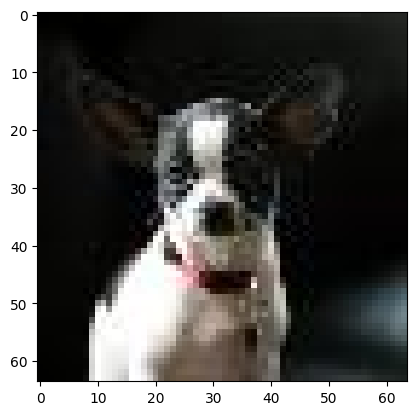

In [17]:
import matplotlib.pyplot as plt
image = imagenet_train[187*500+1]['image']
# show image
plt.imshow(image)

In [19]:
conversation = [{"role": "user", "content": processor.image_token + "\nDescribe the image"}]
prompt = processor.tokenizer.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

def generate(prompt, image, **kwds):
    inp = processor(image, prompt, return_tensors="pt").to(model.device)
    streamer = transformers.TextStreamer(processor.tokenizer, True, skip_special_tokens=True)
    model.generate(**inp, max_new_tokens=256, streamer=streamer, eos_token_id=107, **kwds)

generate(prompt, image)


The image features a small black and white dog sitting in the dark, with its ears perked up. The dog is wearing a red collar, and it appears to be looking at the camera. The dog is positioned in the center of the scene, with its head tilted to the side. The background is dark, creating a dramatic and moody atmosphere.


## Intervene on the activation functions of the Transformer

In [20]:
# 27 - cat
# 4501 - feature in SAE encoding space that corresponds to friendly animals (particuarly dogs)
# Subtract this activation vector in the residual stream of the 12th block of the transformer
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -6))

The image features a close-up of a person's hands holding a cell phone, with the focus on the hands and the surrounding area. The cell phone is in the middle of the hands, with the hands spread out to the sides. The image also includes a background that can be seen in the upper part of the cell phone, and the overall context suggests that the person is using the cell phone.


In [22]:
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -4))

The image features a close-up of a person's hands holding a cell phone, with the focus on the hands and the cell phone. The hands are holding the phone, and the image is in black and white. The cell phone is visible in the middle of the hands, with the hands spread out to the sides.

In the background, there is a person's face, but the main focus remains on the hands and the cell phone. The image captures a moment where the hands are holding the cell phone, possibly for a specific purpose or to display the content on the screen.


In [21]:
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, 2))

The image features a black and white dog sitting on a black surface, possibly a couch or a black table. The dog is wearing a red collar and appears to be looking at the camera. The dog is sitting on a black and white dog bed, which is placed on the black surface. The dog is positioned in the center of the image, with its head tilted to the side.
